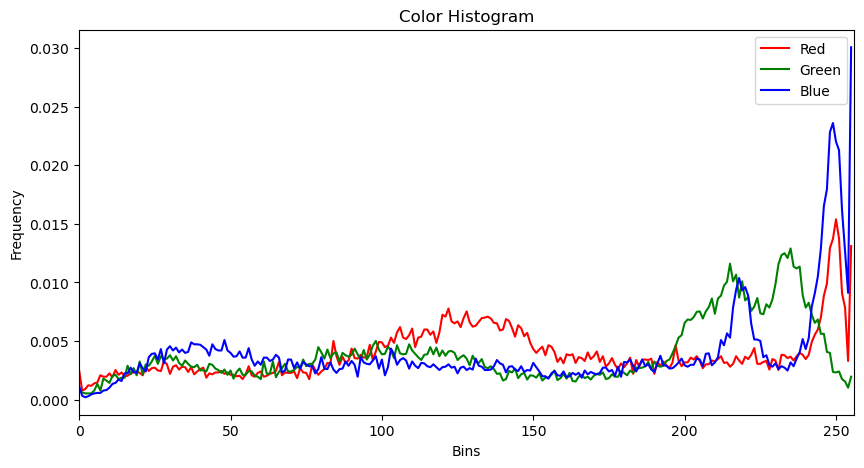

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_color_histogram(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Calculate histograms for R, G, B channels
    hist_r = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [256], [0, 256])

    # Normalize histograms
    hist_r = hist_r / hist_r.sum()
    hist_g = hist_g / hist_g.sum()
    hist_b = hist_b / hist_b.sum()

    # Plot histograms
    plt.figure(figsize=(10, 5))
    plt.title('Color Histogram')
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.xlim([0, 256])
    plt.plot(hist_r, color='red')
    plt.plot(hist_g, color='green')
    plt.plot(hist_b, color='blue')
    plt.legend(['Red', 'Green', 'Blue'])
    plt.show()

# Example usage
calculate_color_histogram('./img/1472.jpg')


In [18]:
import cv2
import numpy as np
import os
import json
from sklearn.cluster import KMeans

def calculate_color_histogram(image):
    hist_r = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [256], [0, 256])
    hist_r = hist_r / hist_r.sum()
    hist_g = hist_g / hist_g.sum()
    hist_b = hist_b / hist_b.sum()
    return hist_r, hist_g, hist_b

def calculate_dominant_colors(image_path, k=16):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(image)
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    color_counts = dict(zip(unique, counts))
    colors = kmeans.cluster_centers_.astype(int)
    total_counts = sum(color_counts.values())
    dominant_colors = [(colors[i].tolist(), count / total_counts) for i, count in color_counts.items() if count / total_counts > 0.05]
    return dominant_colors

def process_images_in_folder(folder_path, k=16):
    results = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is None:
                continue
            hist_r, hist_g, hist_b = calculate_color_histogram(image)
            dominant_colors = calculate_dominant_colors(image_path, k)
            results[filename] = {
                'dominant_colors': dominant_colors,
                'histogram': {
                    'red': hist_r.flatten().tolist(),
                    'green': hist_g.flatten().tolist(),
                    'blue': hist_b.flatten().tolist()
                }
            }
    return results

folder_path = './img'
results = process_images_in_folder(folder_path, k=32)

with open('image_characteristics.json', 'w') as f:
    json.dump(results, f, indent=4)

print("Processed images and saved results to image_characteristics.json")


Processed images and saved results to image_characteristics.json


In [19]:
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def load_image_characteristics(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def calculate_euclidean_distance(hist1, hist2):
    return np.sqrt(np.sum((np.array(hist1) - np.array(hist2)) ** 2))

def calculate_chi_squared_distance(hist1, hist2):
    # Chi-squared distance calculation
    return 0.5 * np.sum(((np.array(hist1) - np.array(hist2)) ** 2) / (np.array(hist1) + np.array(hist2) + 1e-10))

def calculate_cosine_similarity(hist1, hist2):
    return 1 - cosine_similarity([hist1], [hist2])[0][0]

def calculate_global_distances(image1, image2):
    hist1 = image1['histogram']
    hist2 = image2['histogram']
    
    euclidean_dist = calculate_euclidean_distance(hist1['red'], hist2['red']) + \
                     calculate_euclidean_distance(hist1['green'], hist2['green']) + \
                     calculate_euclidean_distance(hist1['blue'], hist2['blue'])

    chi_squared_dist = calculate_chi_squared_distance(hist1['red'], hist2['red']) + \
                       calculate_chi_squared_distance(hist1['green'], hist2['green']) + \
                       calculate_chi_squared_distance(hist1['blue'], hist2['blue'])

    cosine_sim = calculate_cosine_similarity(hist1['red'], hist2['red']) + \
                 calculate_cosine_similarity(hist1['green'], hist2['green']) + \
                 calculate_cosine_similarity(hist1['blue'], hist2['blue'])

    return {
        'euclidean_distance': euclidean_dist,
        'chi_squared_distance': chi_squared_dist,
        'cosine_similarity': cosine_sim
    }

def compare_images(image_characteristics):
    results = {}
    images = list(image_characteristics.keys())
    
    for i in range(len(images)):
        distances = {}
        for j in range(len(images)):
            if i != j:
                img1 = image_characteristics[images[i]]
                img2 = image_characteristics[images[j]]
                global_distances = calculate_global_distances(img1, img2)

                distances[images[j]] = global_distances
        
        results[images[i]] = distances
    
    return results

# Example usage
image_characteristics = load_image_characteristics('image_characteristics.json')
similarity_results = compare_images(image_characteristics)

# Save results to a JSON file with images and their global distances
with open('similarity_results.json', 'w') as f:
    json.dump(similarity_results, f, indent=4)

print("Calculated similarity results and saved to similarity_results.json")


Calculated similarity results and saved to similarity_results.json


In [24]:
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def load_image_characteristics(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def calculate_euclidean_distance(hist1, hist2):
    return np.sqrt(np.sum((np.array(hist1) - np.array(hist2)) ** 2))

def calculate_global_distance(image1, image2):
    hist1 = image1['histogram']
    hist2 = image2['histogram']
    
    euclidean_dist = calculate_euclidean_distance(hist1['red'], hist2['red']) + \
                     calculate_euclidean_distance(hist1['green'], hist2['green']) + \
                     calculate_euclidean_distance(hist1['blue'], hist2['blue'])

    return euclidean_dist

def save_global_distances(image_characteristics, output_file):
    results = {}
    images = list(image_characteristics.keys())
    
    for i in range(len(images)):
        for j in range(i + 1, len(images)):  # To avoid recalculating pairs
            img1 = image_characteristics[images[i]]
            img2 = image_characteristics[images[j]]
            distance = calculate_global_distance(img1, img2)  # Calculate only one distance
            # Store the distance in a readable format
            results[f"{images[i]}_to_{images[j]}"] = distance
    
    # Save results to final.json
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=4)

    print(f"Global distances saved to {output_file}")

# Example usage
image_characteristics = load_image_characteristics('image_characteristics.json')
save_global_distances(image_characteristics, 'final.json')


Global distances saved to final.json


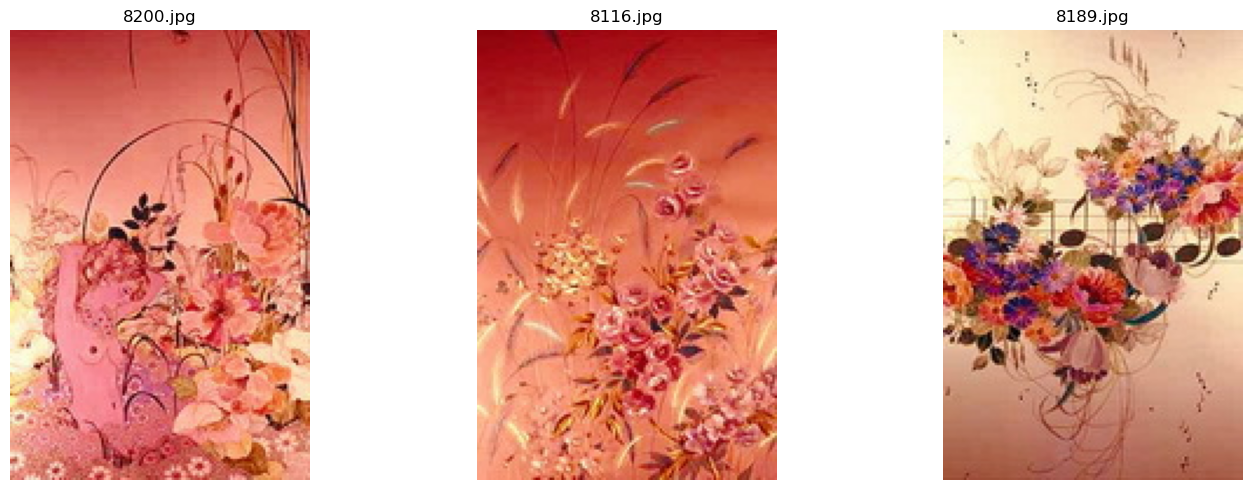

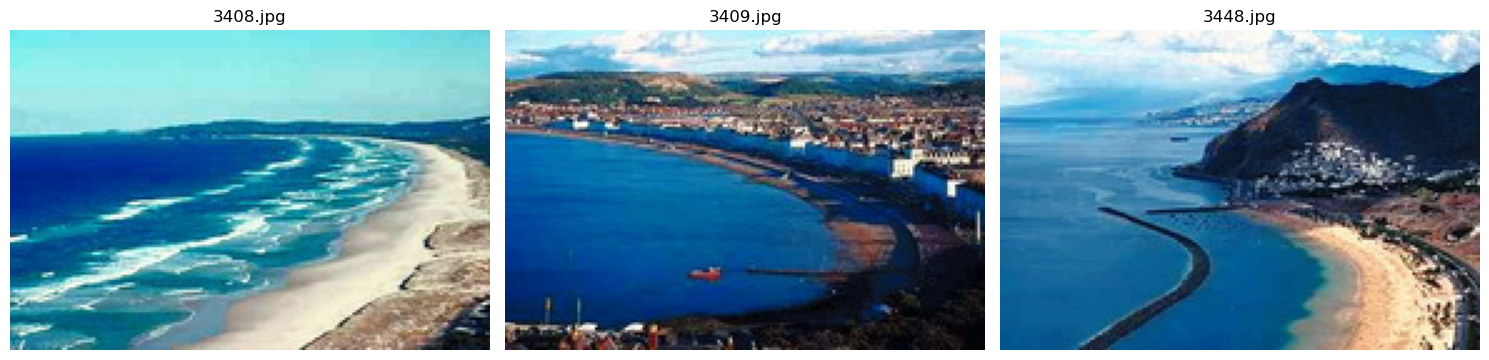

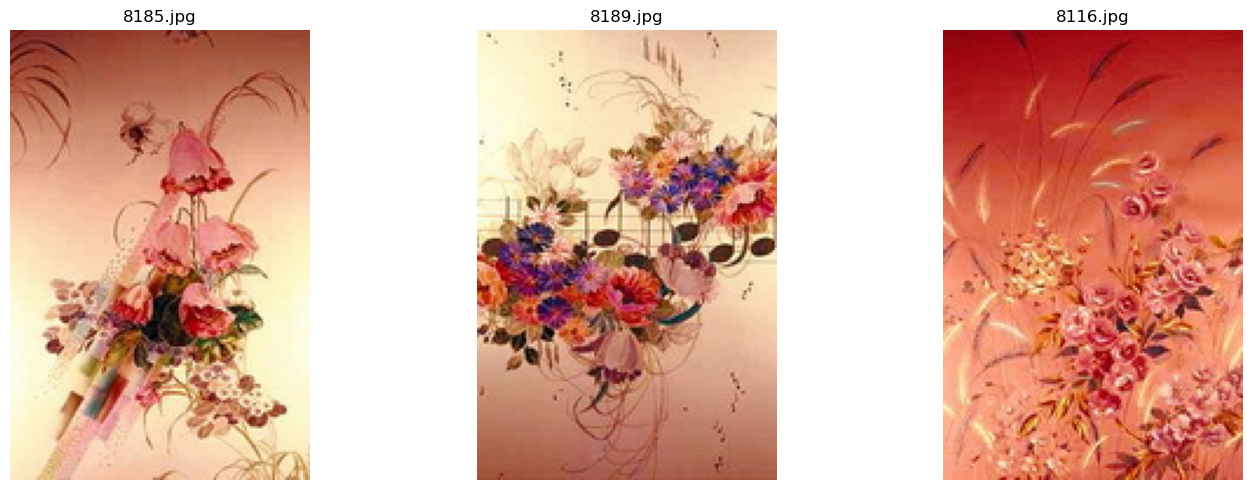

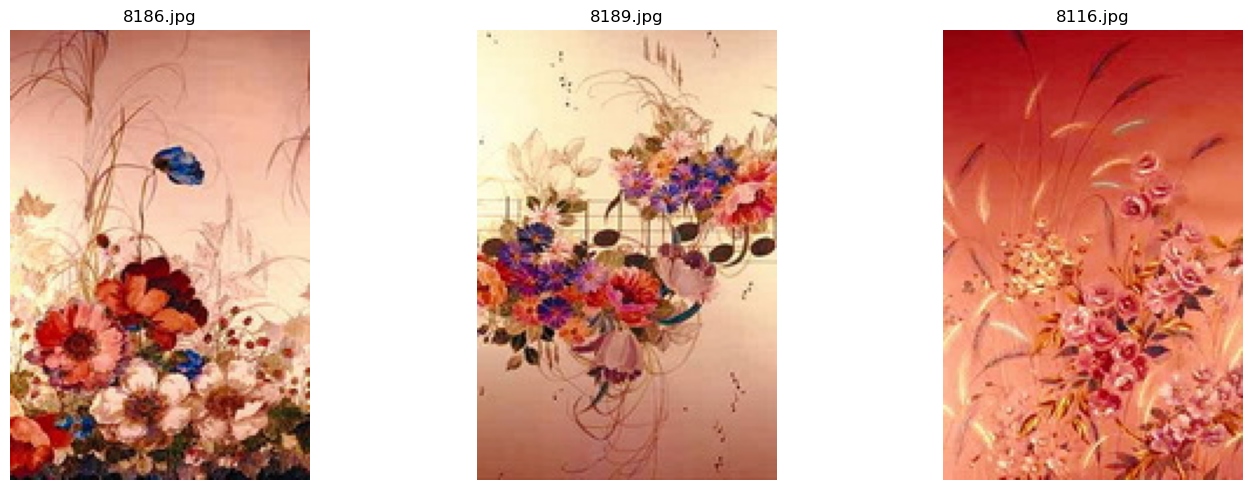

In [27]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

new_folder_path = './test/'  
results = process_images_in_folder(new_folder_path, k=32)

with open('new_image_characteristics.json', 'w') as f:
    json.dump(results, f, indent=4)

image_characteristics = load_image_characteristics('image_characteristics.json')

global_distances = {}

for new_image in results.keys():
    global_distances[new_image] = {}
    for old_image in image_characteristics.keys():
        distance = calculate_global_distance(results[new_image], image_characteristics[old_image])
        global_distances[new_image][old_image] = distance

with open('global_distances.json', 'w') as f:
    json.dump(global_distances, f, indent=4)

new_images_list = list(results.keys())

for i in range(min(4, len(new_images_list))):
    new_image = new_images_list[i]
    distances = global_distances[new_image]
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])[:2]
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(new_folder_path, new_image)), cv2.COLOR_BGR2RGB))
    plt.title(new_image)
    plt.axis('off')

    for idx, similar_image in enumerate(sorted_distances):
        plt.subplot(1, 3, idx + 2)
        plt.imshow(cv2.cvtColor(cv2.imread(os.path.join('./img', similar_image[0])), cv2.COLOR_BGR2RGB))
        plt.title(similar_image[0])
        plt.axis('off')

    plt.tight_layout()
    plt.show()
